<a href="https://colab.research.google.com/github/ChangMarkusYu/masked-face-classifier/blob/master/pca_svm_on_gdrive_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks"

Shape after downsamping: (128, 128)


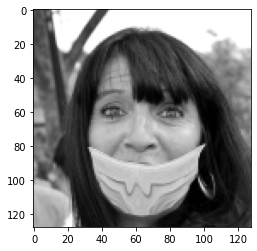

Image Dimension: (128, 128)
mean:[ 1.04083409e-17 -3.46944695e-17  2.04697370e-16  9.54097912e-17
  1.23165367e-16 -5.55111512e-17 -1.73472348e-18  1.63064007e-16
 -6.24500451e-17  7.97972799e-17  6.93889390e-17 -5.03069808e-17
  8.67361738e-19  6.50521303e-18 -1.68701858e-16  2.55871713e-17
  3.72965547e-17 -1.63931368e-16  6.41847686e-17  1.11022302e-16
  5.20417043e-18 -1.14491749e-16  6.07153217e-17  9.19403442e-17
 -1.64798730e-16 -4.51028104e-17 -1.76941795e-16 -2.86229374e-17
  3.16587034e-17  3.46944695e-17 -4.33680869e-17  2.77555756e-17
 -8.67361738e-18 -2.60208521e-17  1.25767452e-16 -1.93421668e-16
  6.93889390e-18  8.50014503e-17  2.60208521e-17  8.67361738e-17
 -1.09287579e-16 -1.07552856e-16 -2.08166817e-17 -4.33680869e-17
 -1.05818132e-16  1.04083409e-16 -1.38777878e-17 -6.59194921e-17
  7.28583860e-17 -2.25514052e-17 -2.08166817e-17  2.42861287e-17
 -1.38777878e-17 -1.90819582e-17  1.90819582e-17  5.20417043e-17
 -7.97972799e-17 -2.08166817e-17 -7.63278329e-17 -3.29597

In [38]:
# test.py
import cv2
import numpy as np
from scipy import stats
from skimage.measure import block_reduce
import matplotlib.pyplot as plt

# playground for testing code snippets

# test_file = './CMFD/00000/00000_Mask.jpg'
train_file='/content/drive/My Drive/masks/train/masked/00000/00000_Mask.jpg'
train_file='/content/drive/My Drive/masks/train/non-masked/02000/02000_Mask_Mouth_Chin.jpg'
test_file='/content/drive/My Drive/masks/test/masked/01301_Mask.jpg'

img = cv2.imread(train_file, cv2.IMREAD_GRAYSCALE)
img = block_reduce(img, block_size=(8, 8), func=np.mean)
print(f"Shape after downsamping: {img.shape}")
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()
# img = img.reshape(1024 * 1024)
img = stats.zscore(img, axis=0)
print(f'Image Dimension: {img.shape}')
print(f'mean:{img.mean(axis=0)}\n stdev: {img.std(axis=0)}')

In [39]:
test=np.array([0,1,2])
print(test!=[])

True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [40]:
# util.py
'''
Utilty functions for pca-svm pipeline and CNN
'''

import os
import glob
import math
import cv2
import time
import pickle
import numpy as np
from joblib import Parallel, delayed, dump
from sklearn.model_selection import train_test_split
from skimage.measure import block_reduce
from scipy import stats

J = 0  # Just load folder 00000 for now
root_path="/content/drive/My Drive/masks"
'''
Read image as gray scale image (1024, 1024). Downsample it to (256,256)
by averaging the pixel values in each 4 by 4 pixel block. Finally,
flatten the 2d matrix into a 1d vector.
Grayscale and downsamping is a must, otherwise the memory cost will be too huge
and blow up my computer
'''


def preprocess_image(im_file):
    img = cv2.imread(im_file, cv2.IMREAD_GRAYSCALE)
    img = block_reduce(img, block_size=(8, 8), func=np.mean).flatten()
    return stats.zscore(img)


'''
Load the images of a particular class label into memory
The shape of the feature matrix X follows the normal convention: (n_samples, n_features)
'''


# def load(class_label):
#     X = []  # input features
#     Y = []  # class labels
#     # input_folder = "CMFD" if class_label == 1 else "IMFD"
#     input_folder = "CMFD" if class_label == 1 else "IMFD"

#     # load correctly masked faces
#     print(f"Loading class: {class_label}")
#     for j in range(J + 1):
#         folder_num = j * 10
#         folder_name = format(folder_num, '05d')
#         print("Now Loading: " + folder_name)
#         path = os.path.join(f'./{input_folder}/', folder_name, '*.jpg')
#         files = glob.glob(path)
#         X.extend(Parallel(n_jobs=-2)(delayed(preprocess_image)(im_file)
#                                      for im_file in files))
#         X = np.asarray(X)
#         Y = np.asarray([class_label] * len(files))
#         return X, Y

def load_train_test(train_test):
    X_train = []  # input features
    Y_train = []  # class labels
    # input_folder = "CMFD" if class_label == 1 else "IMFD"
    input_folder = train_test
      # if class_label == 1 else "test"

    # load correctly masked faces
    print(f"Loading class: {train_test}")
    # for j in range(J + 1):
    #     folder_num = j * 10
    #     folder_name = format(folder_num, '05d')
    #     print("Now Loading: " + folder_name)
    folder_name=["02000","00000"]
    labels=["non-masked","masked"]
    for class_label in [0,1]:
        X = []  # input features
        Y = []  # class labels
        if (train_test=="train"):
          path = os.path.join(f'{root_path}/{input_folder}/{labels[class_label]}/{folder_name[class_label]}/', '*.jpg')
        else:
          path = os.path.join(f'{root_path}/{input_folder}/{labels[class_label]}/', '*.jpg')
        print(path)
        files = glob.glob(path)
        # print(files)
        X.extend(Parallel(n_jobs=-1)(delayed(preprocess_image)(im_file)
                                     for im_file in files))
        X = np.asarray(X)
        Y = np.asarray([class_label] * len(files))
        if X_train!=[]: 
          X_train = np.concatenate((X, X_train), axis=0)
          Y_train = np.concatenate((Y, Y_train), axis=0)
        else: 
          X_train=X 
          Y_train=Y
        # Y_train = np.concatenate((Y, Y_train), axis=0)
    print(X_train.shape)
    print(Y_train.shape)
    return X_train, Y_train

'''
Load image data and shuffle. Use 80/20 train-test split
'''


def load_data():
    X_train,y_train=load_train_test("train")
    X_test, y_test=load_train_test("test")
    
    # X1, Y1 = load(1)
    # X2, Y2 = load(0)
    # X = np.concatenate((X1, X2), axis=0)
    # Y = np.concatenate((Y1, Y2), axis=0)
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, Y, test_size=0.2, shuffle=True)
    return X_train, X_test, y_train, y_test


'''
Save the model as a file to ./model
model_type: saving the pca-svm pipeline or the cnn. Can only be one of 'pca' or 'cnn'
To load the saved model, import load from joblib and then use: clf = load('filepath.joblib')
'''


def model_checkpoint(model, model_type='pca'):
    if model_type != 'pca' and model_type != 'cnn':
        raise ValueError("model_type must be either 'pca' or 'cnn'")

    timestr = time.strftime("%Y%m%d_%H%M%S")
    filename = f"model_{model_type}_{timestr}.joblib"
    filepath = os.path.join(f'{root_path}/model', filename)
    dump(model, filepath)

Loading class: train
/content/drive/My Drive/masks/train/non-masked/02000/*.jpg
/content/drive/My Drive/masks/train/masked/00000/*.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(1949, 16384)
(1949,)
Loading class: test
/content/drive/My Drive/masks/test/non-masked/*.jpg
/content/drive/My Drive/masks/test/masked/*.jpg
(592, 16384)
(592,)
Starting grid search...
Best estimator found by grid search: SVC(C=1000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


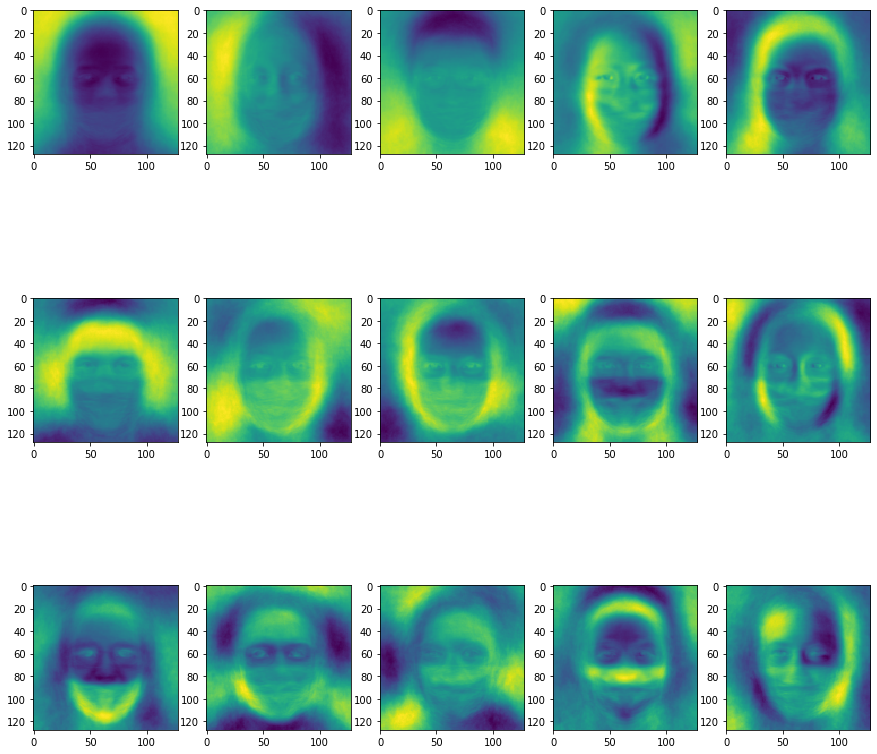

In [41]:

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.svm import SVC
# from util import load_data, model_checkpoint
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = load_data()

target_names = ["Incorrectly maksed", "Correctly masked"]

# PCA - keep the first 30 components
pca = PCA(n_components=30, svd_solver='full')
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# save first 15 eigen faces
fig, axs = plt.subplots(3, 5, figsize=(15,15))
for i in range(3):
    for j in range(5):
        pc = pca.components_[i * 5 + j,:]
        pc = pc.reshape((128,128))
        axs[i, j].imshow(pc, interpolation="nearest")
fig.savefig("eigenfaces.png")

# Hyperparameters
print("Starting grid search...")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf'), param_grid)
clf = clf.fit(X_train, y_train)
print(f"Best estimator found by grid search: {clf.best_estimator_}")



Saving the model to ./model folder...
                    precision    recall  f1-score   support

Incorrectly maksed       0.85      0.86      0.86       299
  Correctly masked       0.86      0.85      0.85       293

          accuracy                           0.85       592
         macro avg       0.85      0.85      0.85       592
      weighted avg       0.85      0.85      0.85       592



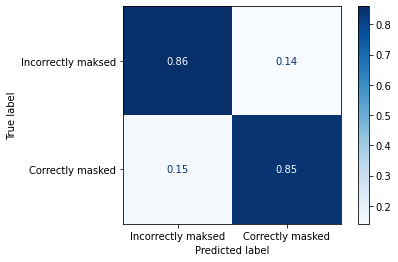

In [42]:

# save the model
print("Saving the model to ./model folder...")
# model_checkpoint(clf, 'pca')

y_predicted = clf.predict(X_test)

# print the classification report
print(classification_report(y_test, y_predicted, target_names=target_names))
# show the confusion matrix
plot_confusion_matrix(clf, X_test, y_test, display_labels=target_names,
                      cmap=plt.cm.Blues, normalize='true')
plt.show()